In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split
embed_dim = 300

KeyboardInterrupt: 

## Albert notes:
- Subword tokenization.
    - advantage: less susceptible to unknown words
    - byte pair encoding, easier to implement
    - word piece
    - sentence piece
        - used by BERT 
        - can't be used with glove 
        - might help with solving the loss of info with discarding one-time occurring words
        - does not necessarily increase RAM a lot 
        
- stratified sampling
    - get mininum sample of each artist 
    - properly write up the training distribution 
    
- for other parts:
    - use weighting
        - TF/IDF
        - easy to implement in sk-learn 
        - 

- which differences are most important
    - just have table which shows results
    - for neural archs:
        - most method-space to neural network architecture explanation (bc focus of assignment)
    - more extensive analysis than just accuracy, try to figure where what goes wrong
    - confusion matrix per genre?
    - which genre/artist are hard to classify 

    
- related literature:
    - writer classification
    - author attribution task   
    - SVM-based tool 
        - https://simonsuster.github.io/publications/Glad.pdf
   
- extra page for per-artist classification

- loss or acc?
    - loss better portrays overfitting 
    - loss and accuracy both increasing also interesting to mention in results
    
- transformers
    - keep current transformer as a base line
    - use pre-trained transformer
        - specify which one and how it is altered 
        - direction AI is going atm 
    - see how directionality works in transformer, look at docs
    - default tf is bidirectional, check!
    
    
- describe final architectures
    - not "tried this didn't work"
    - reproducability important 
    - brief discussion of architecture variations could be good 
    - look at other papers for examples
    
- HP's were set manually (basically by tweaking)
    - better to do HP search, but might not be feasible
    - learning rate important 
   
- bidirectionality works well:
    - 
    
- to discuss:
    - maybe songs with more text are easier to classify? 

## Preprocessing

In [ ]:
import string
import regex as re
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


def preprocess(text):
    # Remove integers
    text = re.sub(r'\d+', '', text)

    # remove newlines as \r and \n
    text = re.sub(r'\r', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation marks
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    return text


def encode_text_and_labels(df, max_num_words, pre_or_post='post'):
    
    # create a tokenizer
    t = Tokenizer(num_words=max_num_words, oov_token='<unk>')
    t.fit_on_texts(df['text'])
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_docs = t.texts_to_sequences(df['text'])
    # pad documents to be as long as the longest sequence in the dataset
    max_length = df['text'].apply(lambda x: len(x.split(' '))).max()
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding=pre_or_post)

    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(df['artist'])
    # binary encode
    onehot_encoded = to_categorical(integer_encoded)
    return padded_docs, onehot_encoded, vocab_size, max_length, t


def load_and_preprocess_data(path, max_num_words, pre_or_post='post'):
    """
    Load the data and preprocess it
    :param path: path to the data
    :return: preprocessed data in the form of a pandas dataframe. The first item returned is the data,
    the second is the labels, the third is the vocabulary size, and the fourth is the maximum length of a sequence
    """
    df = pd.read_csv(path)
    
    df = df.groupby('artist').filter(lambda x: len(x) > 100)

    df['text'] = df['text'].apply(preprocess)

    # Identify the rows that contain duplicated text in the 'song' column
    no_covers = ~df['song'].duplicated()

    # Filter the DataFrame to include only the rows with unique text
    df = df[no_covers]

    # prepare text data for a recurrent network
    return encode_text_and_labels(df, max_num_words, pre_or_post='post')


In [ ]:
from tqdm import tqdm
embedding_vector = {}
f = open(f'/kaggle/input/glove-6b/glove.6B.{embed_dim}d.txt') 
for line in tqdm(f):
    vector = line.split(' ')
    word = vector[0]
    coef = np.asarray(vector[1:],dtype = 'float32')
    embedding_vector[word]=coef
f.close()
print('Number of words found ',len(embedding_vector))

In [ ]:
padded_docs, artists_onehot_encoded, vocab_size, max_length, token = load_and_preprocess_data("/kaggle/input/spotify-million-song-dataset/spotify_millsongdata.csv", None)

In [ ]:
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word,i in tqdm(token.word_index.items()):
    embedding_vectors = embedding_vector.get(word)
    if embedding_vectors is not None:
        embedding_matrix[i] = embedding_vector[word]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, artists_onehot_encoded, test_size=0.2, random_state=42)

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
# class TokenAndPositionEmbedding(layers.Layer):
#     def __init__(self, max_length, vocab_size, embed_dim):
#         super().__init__()
#         self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
#         self.pos_emb = layers.Embedding(input_dim=max_length, output_dim=embed_dim)

#     def call(self, x):
#         max_length = tf.shape(x)[-1]
#         positions = tf.range(start=0, limit=max_length, delta=1)
#         positions = self.pos_emb(positions)
#         x = self.token_emb(x)
#         return x + positions

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 6  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
# embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
embedding_layer = Embedding(vocab_size, embed_dim, input_length=max_length, 
                        weights = [embedding_matrix], trainable = False)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.05)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.05)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.05)(x)
outputs = layers.Dense(artists_onehot_encoded.shape[1], activation="softmax")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
transformer.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
transformer.summary()

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,
                                                    restore_best_weights=True,
                                                    verbose=1)]

history = transformer.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    use_multiprocessing=True
)

In [ ]:
import pickle
with open('/kaggle/working/transformerv2.1_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

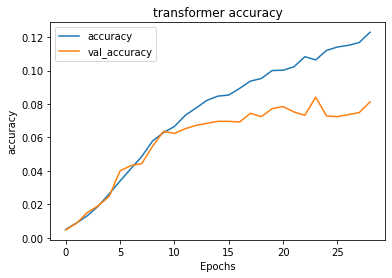

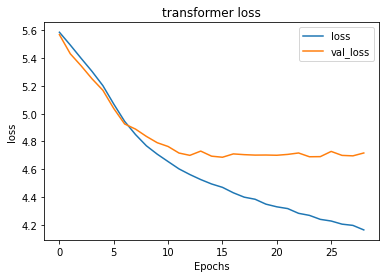

In [45]:
import matplotlib.pyplot as plt
def plot_graphs(history, string, title):
    if type(history) is dict:
        plt.plot(history[string])
        plt.plot(history['val_'+string])
    else:
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(f"{title} {string}")
    plt.show()
    
def plot_model_comparison(history1, history2, string, title):
    plt.plot(history1.history[string])
    plt.plot(history1.history['val_'+string])
    plt.plot(history2.history[string])
    plt.plot(history2.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(f"{title} {string}")
    plt.show()
    
plot_graphs(history, 'accuracy', 'transformer')
plot_graphs(history, 'loss', 'transformer')

# plot_graphs(trainable_history, 'accuracy', 'trainable embedding GRU')
# plot_graphs(trainable_history, 'loss', 'trainable embedding GRU')

In [46]:
with open('/kaggle/working/transformerv2.0_history', "rb") as file_pi:
    abc = pickle.load(file_pi)

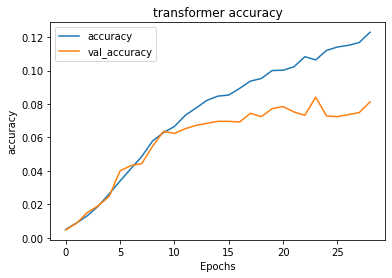

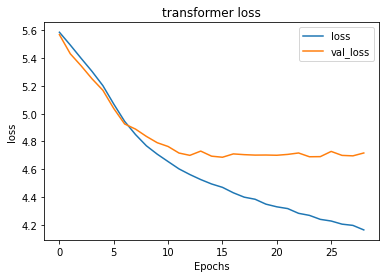

In [47]:
plot_graphs(abc, 'accuracy', 'transformer')
plot_graphs(abc, 'loss', 'transformer')

In [42]:
type(abc)

dict